In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sspspace
import scipy
from scipy.stats import beta, norm

import nengo
import nengo_dft
from nengo.config import Config
from nengo.ensemble import Ensemble
from nengo.network import Network

DNF network used in Striatum for concentrating the salience distribution

In [ ]:
class DNF(Network):
    """A dynamic neural fields network, performing action selection on a bundle of salience-weighted action SSPs.

    Parameters
    ----------
    mode : string, optional (Default: 'continuous')
        The mode for the network to operate in, either continuous or discrete to choose between.
    seed: int, optional (Default: None)
        seed for controlling randomness in network initialisation
    neuron_type : nengo obj, optional (Default: nengo.LIFRate())
        The type of neurons used in the output ensemble. (The DNF network always uses Sigmoid neurons).
    ens_neurons : int, optional (Default: 1000)
        The number of neurons in the output ensemble.
    ens_dims : int, optional (Default: 1)
        Dimensionality of the output ensemble. Should match the dimensionality of the action space.
    dec_neurons : int, optional (Default: 400)
        The number of neurons in the dnf. Equates to the number of place cells used to decode the SSP bundle
        into the salience distribution.
    dnf_h: int, optional (Default: -20)
    dnf_global_inhib: int, optional (Default: 10)
    dnf_tau: float, optional (Default: 0.001)
    kernel_excit: int, optional (Default: 10)
    kernel_inhib: int, optional (Default: 10)
    encoders: array-like, optional (Default: nengo.Default)
        A N X M size array of the encoders for the dnf neurons.
    """
    def __init__(self, seed=None,
                 neuron_type=nengo.LIFRate(),
                 ens_neurons=1000, ens_dims=1,
                 dec_neurons=400,
                 dnf_h=-20, dnf_global_inhib=10, dnf_tau=0.001,
                 kernel_excit=10, kernel_inhib=0,
                 exc_width=5, inh_width=10,
                 encoders=nengo.Default,
                 radius=1.0,
                 ):

        self.seed = seed
        self.neuron_type = neuron_type
        self.ens_neurons = ens_neurons
        self.ens_dims = ens_dims
        self.dnf_neurons = dec_neurons
        self.dnf_h = dnf_h
        self.dnf_global_inhib = dnf_global_inhib
        self.dnf_tau = dnf_tau
        self.encoders = encoders
        self.kernel_excit = kernel_excit
        self.kernel_inhib = kernel_inhib
        self.exc_width = exc_width
        self.inh_width = inh_width
        self.radius = radius

        config = Config(Ensemble)
        config[Ensemble].neuron_type = self.neuron_type

        self.model = nengo.Network(seed=self.seed)
        with self.model:
            # self.state = np.zeros(self.ens_dims)
            with config:

                ## input node
                self.input = nengo.Node(label="input", size_in=self.ens_dims)

                ## layers for breaking bundle into saliences
                self.dnf = nengo_dft.DFT(shape=[self.dnf_neurons], h=self.dnf_h,
                                    global_inh=self.dnf_global_inhib, tau=self.dnf_tau,
                                    radius=self.radius)
                self.dnf.add_kernel(exc=self.kernel_excit, inh=self.kernel_inhib,
                               exc_width=self.exc_width, inh_width=self.inh_width)

                ## connect stimulus to dft
                nengo.Connection(self.input, self.dnf.s, transform=self.encoders, synapse=None)

                ## create output node for interacting with outside networks
                self.output = nengo.Node(label="output", size_in=self.ens_dims)
                ## connect neuron activities to output and re-encode as SSP bundle
                nengo.Connection(self.dnf.g.neurons, self.output, transform=self.encoders.T, synapse=0.01)

Basal Ganglia network

In [ ]:
class DNF_BG_DYNDA(Network):
    """An action selection model using the DNF to perform competition resolution.
    Takes, as input, a bundle of salience-weighted action SSPs and a float value
    representing the amount of dopamine.

    Parameters
    ----------
    neuron_type : nengo obj, optional (Default: nengo.LIFRate())
        The type of neurons used in the output ensemble. (The DNF network always uses Sigmoid neurons).
    dnf_params :  dictionary, optional (DNF net has its own defaults)
        A dictionary of the values for the parameters of the DNF network
    ssp_dim : int, optional (Default: 1)
        Dimensionality of the SSP input. Should be the same as the ens_dims parameter of the DNF
    """

    def __init__(self, seed=None,
                 neuron_type=nengo.LIFRate(),
                 dnf_params=None,
                 encoders=nengo.Default,
                 d1_weight=1.0,
                 d2_weight=1.0,
                ):
        self.seed = seed
        self.ssp_dim = dnf_params['ens_dims']
        self.encoders = encoders

        self.gaba = None #0.008
        self.ampa = 0.0 #0.002

        config = Config(Ensemble)
        config[Ensemble].neuron_type = neuron_type

        # self.model = nengo.Network(seed=self.seed)
        # with self.model:
        with config:

            ## create an input node
            self.input = nengo.Node(label="input", size_in=self.ssp_dim)

            ## create an dopamine node
            self.dopamine = nengo.Node(label="dopamine", size_in=1)

            ## ensemble where we'll multiply the input by the weight +/- dopamine
            inp_times_dop = nengo.Ensemble(n_neurons=1000, dimensions=513, neuron_type=nengo.Direct(), radius=1.0)

            ## create a population of D1 neurons, these will be made to fire faster in the presence of dopamine
            striatum_d1 = DNF(**dnf_params,
                     encoders=self.encoders)
            ## create a population of D2 neurons, these will fire less frequently in the presence of dopamine
            striatum_d2 = DNF(**dnf_params,
                     encoders=self.encoders)

            ## now we need the indirect pathway.
            gpe = nengo.Ensemble(n_neurons=1000,
                            dimensions=self.ssp_dim,
                            radius=1.0,
                            neuron_type=nengo.LIFRate()
                            )

            stn = nengo.Ensemble(n_neurons=1000,
                            dimensions=self.ssp_dim,
                            radius=1.0,
                            neuron_type=nengo.LIFRate()
                            )

            ## next we'll set up the direct pathway, creating the GPi and connecting the D1 neurons directly to it
            gpi = nengo.Ensemble(n_neurons=1000,
                                dimensions=self.ssp_dim,
                                radius=1.0,
                                neuron_type=nengo.LIFRate()
                                )

            ## finally, we need an output node to collect the result
            self.output = nengo.Node(size_in=self.ssp_dim)

            def product_d1(x):
                return x[:512] * (d1_weight + x[-1])

            def product_d2(x):
                return x[:512] * (d2_weight - x[-1])

            ## transform the input
            nengo.Connection(self.input, inp_times_dop[:512], synapse = None)
            nengo.Connection(self.dopamine, inp_times_dop[-1], synapse = None)
            ## connect input to striatum and stn
            nengo.Connection(inp_times_dop, striatum_d1.input, function=product_d1, synapse=None)
            nengo.Connection(inp_times_dop, striatum_d2.input, function=product_d2, synapse=None)
            nengo.Connection(self.input, stn, synapse=None)
            ## indirect pathway connections
            nengo.Connection(striatum_d2.output, gpe, transform=-1.0, synapse=self.gaba)
            nengo.Connection(stn, gpe, transform=1.0, synapse=self.ampa)
            nengo.Connection(gpe, gpi, transform=-1.0, synapse=self.gaba)
            nengo.Connection(gpe, stn, transform=-1.0, synapse=self.gaba)
            ## hyperdirect pathway connections
            nengo.Connection(stn, gpi, transform=1.0, synapse=self.ampa)
            ## direct pathway connection
            nengo.Connection(striatum_d1.output, gpi, transform=-1.0, synapse=self.gaba)
            ## output connection
            nengo.Connection(gpi, self.output, transform=-3.0, synapse=None)

DNF parameters

In [ ]:
dnf_params = {'dnf_h'           : -3.009416816439706,
              'dnf_global_inhib': 8.641108231311897,
              'dnf_tau'         : 0.04706404390267922,
              'kernel_excit'    : 9.421285790349613,
              'kernel_inhib'    : 1.4841093480380807,
              'exc_width'       : 8.534993467227224,
              'inh_width'       : 4.748154014869723,
              'ens_dims'        : 512,
              'dec_neurons'     : 400,
        }

SSP encoder and neuron encoders

In [ ]:
## create SSP encoder and neuron encoders

## set action space domain
domain = np.arange(0,4,0.01).reshape((-1,1))
## create SSP encoder
ssp_encoder = sspspace.RandomSSPSpace(domain_dim=1, ssp_dim=512,
                                      rng=np.random.RandomState(),
                                      length_scale=0.5)
## encode domain as SSPs
domain_phis = ssp_encoder.encode(domain)

## Encoders
low = 0
high = 4
width = high - low
places_ = np.arange(low, high, width/400)
encoders = np.asarray(ssp_encoder.encode(places_.reshape(-1,1))).squeeze()

Create a salience distribution to use as input

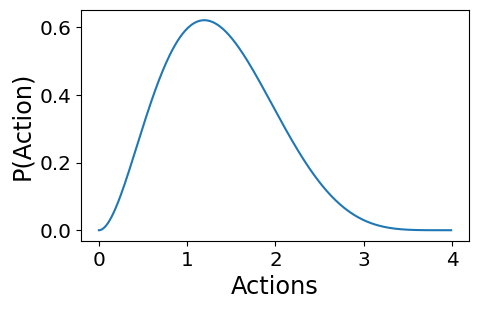

In [ ]:
## Generate a unimodal distribution

## generate random values for the beta distribution
seed = 16
np.random.seed(seed)
a = np.random.uniform(1,10,1)
b = np.random.uniform(1,10,1)

## generate beta distribution
beta_Ps = beta.pdf(domain, a,b, scale=domain[-1])
## encode as an SSP bundle
beta_pattern = np.einsum('n,nd->d', beta_Ps.squeeze(), domain_phis)

plt.figure(figsize=(5,3))

plt.plot(domain, beta_Ps)
plt.xlabel("Actions", fontsize="xx-large")
plt.ylabel("P(Action)", fontsize="xx-large")
plt.tick_params("both", labelsize="x-large")

Nengo Model for passing input to the basal ganglia and reading the output

In [ ]:
d1_weight = 1.0
d2_weight = 1.0
dopamine = 0.2

## Create nengo model
model = nengo.Network()
with model:
    ## node for passing in the input pattern
    inp_node = nengo.Node(nengo.processes.PresentInput([beta_pattern], presentation_time=1.5))
    ## node for passing in the tonic dopamine levels
    da_node = nengo.Node(nengo.processes.PresentInput([dopamine], presentation_time=0.5))
    ## basal ganglia network
    bg = DNF_BG_DYNDA(dnf_params=dnf_params,
            encoders=encoders,
            d1_weight=d1_weight,
            d2_weight=d2_weight,)
    ## node for collecting the output from the basal ganglia
    out_node = nengo.Node(size_in = 512)
    ## connect the input to the basal ganglia input
    nengo.Connection(inp_node, bg.input, synapse=None)
    ## connect the dopamine to the basal ganglia dopamine
    nengo.Connection(da_node, bg.dopamine, synapse=None)
    ## connect the basal ganglia output to the output
    nengo.Connection(bg.output, out_node, synapse=None)

    ## probes for collecting data
    p_in = nengo.Probe(inp_node, synapse=None)
    p_out = nengo.Probe(out_node, synapse=None)

## create and run the simulator
with nengo.Simulator(model) as sim:
    sim.run(1.5)


c:\Users\maddy\anaconda3\envs\bgdlenv\lib\site-packages\nengo\cache.py:617: UserWarning: Decoder cache could not acquire lock and was deactivated.
  warnings.warn("Decoder cache could not acquire lock and was deactivated.")


Build finished in 0:00:11.                                                      
Simulation finished in 0:00:21.                                                 


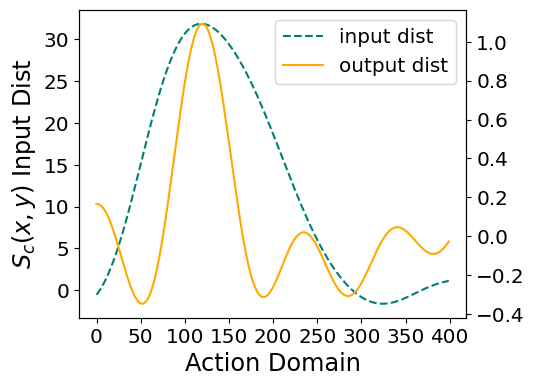

In [ ]:
## decode the collected data
inp_dec_uni = np.einsum('d,nd->n', sim.data[p_in][-1], domain_phis)
out_dec_uni = np.einsum('d,nd->n', sim.data[p_out][-1], domain_phis)

## plot the input and output distributions on the final timestep
fig = plt.figure(figsize=(5,4))

ax1 = fig.add_subplot(111)
## plot the input
ax1.plot(inp_dec_uni, ls='--', color="#007e74", label=f"input dist")
ax1.set_ylabel('$S_{c}(x,y)$ Input Dist', fontsize='xx-large')
plt.yticks(fontsize='x-large')
plt.xticks(fontsize='x-large')
## create second y-axis
ax2 = ax1.twinx()
## plot the output
ax2.plot(out_dec_uni, ls='-', color="#ffaa00", label=f"output dist")
ax1.set_xlabel('Action Domain', fontsize='xx-large')
h1, l1 = ax1.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()
ax1.legend(h1+h2, l1+l2, loc='upper right', fontsize='x-large')
plt.yticks(fontsize='x-large')
plt.show()